In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [28]:
data = pd.read_csv("adult.data", header=None, delimiter=r",\s+", engine='python')
data.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

In [29]:
## replace "?"
var = data['NativeCountry'].mode()
data['NativeCountry'] = data['NativeCountry'].replace('?',var[0])

data['WorkClass'] = data['WorkClass'].map({ 
    "Private": "Private", 
    "?": "Private", 
    "Self-emp-not-inc": 'Not-inc',
    "Without-pay": 'Not-inc',
    "Never-worked": 'Not-inc',
    "State-gov": 'State-gov',
    "Federal-gov": 'Federal-gov',
    "Local-gov": 'Local-gov',
    "Self-emp-inc": 'Self-emp-inc'
})

# on garde '?' comme une nouvelle classe : 'unknown'
data['Occupation'] = pd.Series(['Unknown' if item == '?' else item for item in data["Occupation"]])

In [30]:
data['NativeCountry'] = pd.Series([1 if item == 'United-States' else 0 for item in data["NativeCountry"]])

In [31]:
# a mon avis, on peut inclure ces deux colonne comme deux colonnes (married ? 1:0, haveChild ? 1:0)
data['MaritalStatus'] = data["MaritalStatus"].map({ 
    "Divorced": 0, 
    "Married-AF-spouse": 1,
    "Married-civ-spouse": 1,
    "Married-spouse-absent": 0,
    "Never-married": 0,
    "Separated": 0,
    "Widowed": 0
})
data['HasChild'] = pd.Series([1 if item == 'Own-child' else 0 for item in data["Relationship"]])
data = data.drop(['Relationship'], axis=1)

In [17]:
data['CapitalChange'] = data['CapitalGain'] - data['CapitalLoss']
data = data.drop(['CapitalGain', 'CapitalLoss'], axis=1)

In [18]:
df = pd.get_dummies(data, columns=["WorkClass", "EducationNum", "Occupation", "Race", "Gender"])

In [32]:
## Capital
def sep_capital(capital):
    if capital<0:
        return '1'
    elif capital==0:
        return '2'
    elif 0<capital<=50000:
        return '3'
    elif 50000<capital:
        return '4'

data['CapitalChange'] = (data['CapitalGain'] - data['CapitalLoss']).apply(sep_capital)
data = data.drop(['CapitalGain', 'CapitalLoss'], axis=1)

In [33]:
df = pd.get_dummies(data, columns=["WorkClass", "EducationNum", "Occupation", "Race", "Gender", "CapitalChange", "NativeCountry"])


In [34]:
fnlwgt = df['fnlwgt']
income = df['Income']
X = df.drop(['fnlwgt', 'Income', 'Education'], axis=1)
X

Age  MaritalStatus  HoursPerWeek  NativeCountry  HasChild  \
0       39              0            40              1         0   
1       50              1            13              1         0   
2       38              0            40              1         0   
3       53              1            40              1         0   
4       28              1            40              0         0   
...    ...            ...           ...            ...       ...   
32556   27              1            38              1         0   
32557   40              1            40              1         0   
32558   58              0            40              1         0   
32559   22              0            20              1         1   
32560   52              1            40              1         0   

       WorkClass_Federal-gov  WorkClass_Local-gov  WorkClass_Not-inc  \
0                          0                    0                  0   
1                          0                    0                  1   
2                          0                    0                  0   
3                          0                    0                  0   
4                          0                    0                  0   
...                      ...                  ...                ...   
32556                      0                    0                  0   
32557                      0                    0                  0   
32558                      0                    0                  0   
32559                      0                    0                  0   
32560                      0                    0                  0   

       WorkClass_Private  WorkClass_Self-emp-inc  ...  \
0                      0                       0  ...   
1                      0                       0  ...   
2                      1                       0  ...   
3                      1                       0  ...   
4                      1                       0  ...   
...                  ...                     ...  ...   
32556                  1                       0  ...   
32557                  1                       0  ...   
32558                  1                       0  ...   
32559                  1                       0  ...   
32560                  0                       1  ...   

       Race_Asian-Pac-Islander  Race_Black  Race_Other  Race_White  \
0                            0           0           0           1   
1                            0           0           0           1   
2                            0           0           0           1   
3                            0           1           0           0   
4                            0           1           0           0   
...                        ...         ...         ...         ...   
32556                        0           0           0           1   
32557                        0           0           0           1   
32558                        0           0           0           1   
32559                        0           0           0           1   
32560                        0           0           0           1   

       Gender_Female  Gender_Male  CapitalChange_1  CapitalChange_2  \
0                  0            1                0                0   
1                  0            1                0                1   
2                  0            1                0                1   
3                  0            1                0                1   
4                  1            0                0                1   
...              ...          ...              ...              ...   
32556              1            0                0                1   
32557              0            1                0                1   
32558              1            0                0                1   
32559              0            1                0                1   
32560             

In [35]:
sumWgt = float(np.sum(fnlwgt))
Dp = np.diag(fnlwgt/sumWgt)

In [36]:
X = X.to_numpy()

X = X - X.mean(axis=0)

# transfer = MinMaxScaler(feature_range=(0,1))
# X = transfer.fit_transform(X)

# transfer = StandardScaler()
# X = transfer.fit_transform(X)

In [37]:
V = np.matmul(np.matmul(np.transpose(X), Dp), X)

val_p, vect_p = linalg.eigh(V)
sorted_indices = np.argsort(-val_p)
val_p = val_p[sorted_indices]
vect_p = vect_p[:,sorted_indices]

In [38]:
np.transpose(V) == V

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

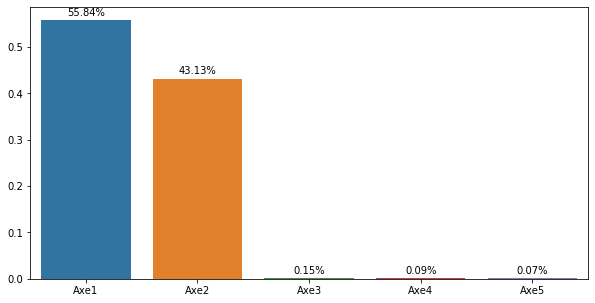

In [39]:
U = vect_p
C = np.matmul(X, U)
sumVal = np.sum(val_p)
inertie_pourcentage = val_p / sumVal

fig = plt.figure(figsize=(10, 5))
ax = sns.barplot([f"Axe{i}" for i in range(1,6)],inertie_pourcentage[0:5])
for (v, p) in zip(inertie_pourcentage[0:5], ax.patches[0:5]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{:1.2f}%'.format((v)*100),
            ha="center") 
plt.show()

In [22]:
val_p

array([ 3.21000560e+00,  2.85071219e+00,  2.35607182e+00,  2.11788865e+00,
        1.75242321e+00,  1.58997067e+00,  1.58531677e+00,  1.50733325e+00,
        1.47526603e+00,  1.45798694e+00,  1.42047431e+00,  1.38739470e+00,
        1.35967887e+00,  1.33962105e+00,  1.32827643e+00,  1.28399369e+00,
        1.27393954e+00,  1.25910721e+00,  1.23881570e+00,  1.22926295e+00,
        1.20619376e+00,  1.20394487e+00,  1.17530660e+00,  1.16140836e+00,
        1.15506258e+00,  1.14083714e+00,  1.13329223e+00,  1.12341783e+00,
        1.12007849e+00,  1.11369594e+00,  1.10955489e+00,  1.09646516e+00,
        1.09609134e+00,  1.08087585e+00,  1.07467114e+00,  1.07289537e+00,
        1.07131709e+00,  1.06883279e+00,  1.05807349e+00,  1.05770257e+00,
        1.04526041e+00,  1.03553600e+00,  1.03034117e+00,  1.02316595e+00,
        1.00883570e+00,  1.00366041e+00,  9.97540966e-01,  9.94962905e-01,
        9.92056083e-01,  9.84928323e-01,  9.83007839e-01,  9.72641362e-01,
        9.70814964e-01,  

[[ 2.25222466e-01  3.64002313e-01  2.54595417e-01 ...  5.87366177e-02
  -2.62012153e-02  5.07428453e-03]
 [ 5.54620145e-02  8.03966612e-02  4.46258653e-02 ... -5.09728154e-01
   1.36922321e-01  2.03985995e-02]
 [ 1.17787384e-01 -6.04878496e-02  2.24988861e-02 ...  9.35422436e-02
   6.16289078e-03 -1.24353089e-02]
 ...
 [-7.62518149e-17  1.20311146e-17 -1.84195477e-17 ...  2.55935760e-01
   4.13148355e-02  2.02054798e-02]
 [ 0.00000000e+00 -1.41615620e-17 -2.74310837e-16 ...  3.61818519e-01
   5.84071275e-02  2.85646553e-02]
 [ 0.00000000e+00 -3.12250226e-17  6.03342336e-17 ...  1.44228915e-02
   2.32823811e-03  1.13865074e-03]]
[3.25305295e+00 2.52170261e+00 2.34989306e+00 1.87872047e+00
 1.72082477e+00 1.56801674e+00 1.50152645e+00 1.41149030e+00
 1.37206859e+00 1.29247988e+00 1.25924408e+00 1.21740979e+00
 1.20509718e+00 1.19596797e+00 1.16992622e+00 1.14800934e+00
 1.13576307e+00 1.12892897e+00 1.10758491e+00 1.09631878e+00
 1.09438470e+00 1.08547000e+00 1.08275510e+00 1.07105552e+0

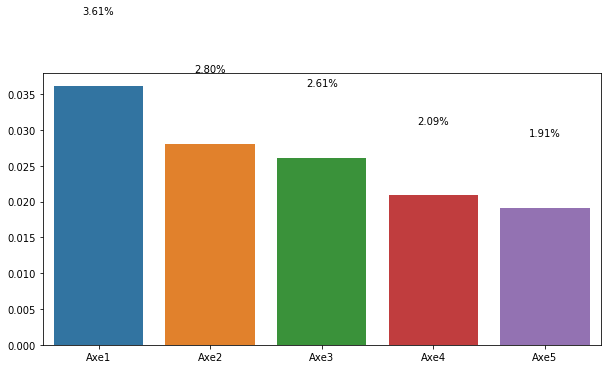

In [25]:
from sklearn.decomposition import PCA

cls = PCA(n_components=90)
cls.fit_transform(X)
print(cls.components_) #新的基
print(cls.explained_variance_) #inertie expliquée
print(cls.explained_variance_ratio_)

fig = plt.figure(figsize=(10, 5))
ax = sns.barplot([f"Axe{i}" for i in range(1,6)],cls.explained_variance_ratio_[0:5])
for (v, p) in zip(cls.explained_variance_ratio_[0:5], ax.patches[0:5]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{:1.2f}%'.format((v)*100),
            ha="center") 
plt.show()

In [40]:
new_data = pd.DataFrame(C[:, 0:2], columns=['Axe1', 'Axe2'])
Xy = pd.concat([new_data, income], axis=1)

plt.figure(figsize=(10,10))
sns.scatterplot(x="Axe1", y="Axe2", hue="Income", data=Xy)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
cls = KMeans(n_clusters=2, init="random")
cls.fit(new_data)
print(cls.labels_)
print(cls.cluster_centers_)
print(cls.inertia_)

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Axe1", y="Axe2", hue="Income", style=cls.labels_, data=Xy)
plt.show()

In [ ]:
from src.utils import plot_clustering
from src.adaptive_kmeans import AdaptiveKMeans

cls = AdaptiveKMeans(n_clusters=2)
labels = cls.fit_predict(C) 

plt.figure(figsize=(10,8))
labels = pd.Series(labels, name="K-means")
plot_clustering(new_data, clus1=labels, clus2=income, centers=cls.cluster_centers_, covars=cls.covars_)
plt.show()